In [1]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, auc, log_loss, roc_curve
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings("ignore")

/Users/yashmahajan/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
preproccessed_train_df = pd.read_csv(r'./preprocessedData/train-preprocessed.csv')
preproccessed_test_df = pd.read_csv(r'./preprocessedData/test-preprocessed.csv')

In [3]:
preproccessed_train_df.shape

(276759, 212)

In [4]:
preproccessed_test_df.shape

(30752, 212)

In [5]:
preproccessed_train_df.head()

,Unnamed: 0,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,...,pca-2,pca-3,pca-4,pca-5,pca-6,pca-7,pca-8,pca-9,pca-10,TARGET
0,197245,328695,0.001243,0.082876,0.073938,0.057239,0.079177,0.825957,0.197802,0.000000,...,-0.180707,0.191229,0.270126,0.050621,-0.149566,0.217995,0.094645,-0.020663,0.072244,0
1,180379,309048,0.001320,0.021348,0.049017,0.022447,0.226010,0.584549,0.087912,0.105263,...,-0.250685,-0.051708,-0.025450,-0.077051,-0.020953,0.074114,-0.025650,0.013826,0.044659,0
2,42671,149398,0.001158,0.124719,0.062197,0.125701,0.276330,0.765078,0.098901,0.000000,...,-0.092176,0.003207,-0.064521,0.014502,-0.044643,-0.036465,-0.017203,0.011350,0.015536,0
3,128201,248704,0.001050,0.207029,0.184574,0.191919,0.245631,0.972357,0.098901,0.105263,...,0.132030,-0.135607,-0.122080,0.030635,-0.033998,-0.051394,-0.023131,0.018059,0.052966,0
4,268208,410783,0.001127,0.101124,0.132362,0.102132,0.491595,0.803948,0.098901,0.157895,...,-0.156779,-0.484716,-0.113124,0.003474,0.092111,-0.001448,-0.112061,0.012328,0.003772,0


In [6]:
preproccessed_test_df.head()

,Unnamed: 0,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,...,pca-2,pca-3,pca-4,pca-5,pca-6,pca-7,pca-8,pca-9,pca-10,TARGET
0,103812,220485,0.000742,0.046067,0.039663,0.047138,0.197042,0.945687,0.098901,0.000000,...,0.107450,-0.099475,-0.146964,0.188104,0.035622,-0.052144,-0.085002,-0.039655,-0.094613,0
1,33350,138637,0.000473,0.197348,0.137206,0.158249,0.276330,0.944147,0.714286,0.052632,...,-0.227368,-0.033126,-0.154565,-0.073216,-0.097993,0.058892,-0.016059,0.013575,0.026204,0
2,118785,237745,0.000550,0.089888,0.072675,0.090909,0.260475,0.818337,0.032967,0.105263,...,0.022146,0.511970,0.058970,0.710577,-0.137946,0.446751,0.154910,0.201776,0.561764,0
3,178204,306505,0.001166,0.131937,0.062004,0.113356,0.254009,0.686000,0.098901,0.000000,...,0.097375,0.142600,0.020987,-0.070686,0.021521,-0.108220,-0.073644,0.002924,0.012265,1
4,114405,232670,0.000935,0.056180,0.046350,0.057239,0.129705,0.880512,0.098901,0.000000,...,-0.005728,-0.017172,0.126068,0.008221,-0.038237,0.020835,-0.017789,-0.022715,-0.063745,0


In [7]:
X_train_df = preproccessed_train_df.drop(columns=["Unnamed: 0", "SK_ID_CURR", "TARGET"])
X_test_df = preproccessed_test_df.drop(columns=["Unnamed: 0", "SK_ID_CURR", "TARGET"])

In [8]:
X_train_df.head()
X_test_df.head()

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,...,pca-1,pca-2,pca-3,pca-4,pca-5,pca-6,pca-7,pca-8,pca-9,pca-10
0,0.000742,0.046067,0.039663,0.047138,0.197042,0.945687,0.098901,0.000000,0.518318,0.489246,...,-0.317886,0.107450,-0.099475,-0.146964,0.188104,0.035622,-0.052144,-0.085002,-0.039655,-0.094613
1,0.000473,0.197348,0.137206,0.158249,0.276330,0.944147,0.714286,0.052632,0.738676,0.302528,...,0.327519,-0.227368,-0.033126,-0.154565,-0.073216,-0.097993,0.058892,-0.016059,0.013575,0.026204
2,0.000550,0.089888,0.072675,0.090909,0.260475,0.818337,0.032967,0.105263,0.518318,0.766339,...,0.363630,0.022146,0.511970,0.058970,0.710577,-0.137946,0.446751,0.154910,0.201776,0.561764
3,0.001166,0.131937,0.062004,0.113356,0.254009,0.686000,0.098901,0.000000,0.723398,0.745044,...,-0.107483,0.097375,0.142600,0.020987,-0.070686,0.021521,-0.108220,-0.073644,0.002924,0.012265
4,0.000935,0.056180,0.046350,0.057239,0.129705,0.880512,0.098901,0.000000,0.321969,0.301582,...,-0.380793,-0.005728,-0.017172,0.126068,0.008221,-0.038237,0.020835,-0.017789,-0.022715,-0.063745


In [9]:
Y_train_df = preproccessed_train_df[["TARGET"]]
Y_test_df = preproccessed_test_df[["TARGET"]]

In [10]:
Y_train_df.head()
Y_test_df.head()

,TARGET
0,0
1,0
2,0
3,1
4,0


In [11]:
print(Y_train_df.shape)
print(X_train_df.shape)

(276759, 1)
(276759, 209)


In [12]:
model = lgb.LGBMClassifier()
model.fit(X_train_df, Y_train_df)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [13]:
y_pred = model.predict_proba(X_test_df)

In [14]:
y_pred_df = y_pred[:, 1]
y_pred_df

array([0.24786863, 0.04279469, 0.03166757, ..., 0.05882264, 0.0466956 ,
       0.05165279])

In [15]:
[fpr, tpr, thr] = roc_curve(Y_test_df, y_pred_df)
print("Light Gradient Boosting Machine Base Case  log_loss: %2.3f" % log_loss(Y_test_df, y_pred_df))
print("Light Gradient Boosting Machine Base Case auc: %2.3f" % auc(fpr, tpr))

Light Gradient Boosting Machine Base Case  log_loss: 0.243
Light Gradient Boosting Machine Base Case auc: 0.759


In [16]:
def plot_roc_curve(false_positive, true_positive):
    plt.step(false_positive, true_positive, alpha=0.3, color='green')
    plt.fill_between(false_positive, true_positive, alpha=0.2, color='green')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('ROC-AUC curve: AUC={0:0.3f}'.format(auc(fpr, tpr)))

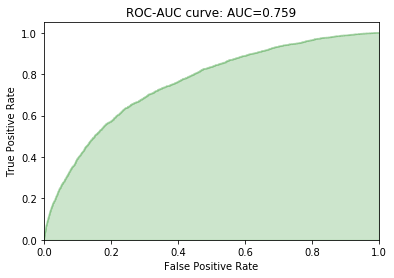

In [17]:
plot_roc_curve(fpr,tpr)

In [18]:
def lgbm(maxDepth, nEstimator, learningRate):
    lgbm_model = lgb.LGBMClassifier(max_depth=maxDepth, n_estimators=nEstimator, learning_rate= learningRate )
    lgbm_model.fit(X_train_df, Y_train_df)
    y_pred = lgbm_model.predict_proba(X_test_df)
    y_pred_df = y_pred[:, 1]
    [fpr, tpr, thr] = roc_curve(Y_test_df, y_pred_df)
    #print("Light Gradient Boosting Machine Base Case  log_loss: %2.3f" % log_loss(Y_test_df, y_pred_df))
    print("Light Gradient Boosting Machine with maxDepth: {}, nEstimator: {}, learningRate: {} baseline log_loss: %2.3f".format(maxDepth, nEstimator, learningRate) % log_loss(Y_test_df, y_pred_df))
    print("Light Gradient Boosting Machine Base Case auc: %2.3f" % auc(fpr, tpr))
    return auc(fpr, tpr)

In [19]:
maxDepth = [0, 5, 10]

In [20]:
nEstimator = [400, 1000, 2000]

In [21]:
learningRate = [0.03, 0.05, 0.07]

In [22]:
area_under_curve = []
params = []
for depth in maxDepth:
    for estimator in nEstimator:
        for lRate in learningRate:
            params.append("max_depth: {}, n_estimator: {}, learning_rate: {}".format(depth, estimator, lRate))
            area_under_curve.append(lgbm(maxDepth=depth, nEstimator=estimator, learningRate=lRate))

Light Gradient Boosting Machine with maxDepth: 0, nEstimator: 400, learningRate: 0.03 baseline log_loss: 0.243
Light Gradient Boosting Machine Base Case auc: 0.761
Light Gradient Boosting Machine with maxDepth: 0, nEstimator: 400, learningRate: 0.05 baseline log_loss: 0.243
Light Gradient Boosting Machine Base Case auc: 0.761
Light Gradient Boosting Machine with maxDepth: 0, nEstimator: 400, learningRate: 0.07 baseline log_loss: 0.244
Light Gradient Boosting Machine Base Case auc: 0.758
Light Gradient Boosting Machine with maxDepth: 0, nEstimator: 1000, learningRate: 0.03 baseline log_loss: 0.243
Light Gradient Boosting Machine Base Case auc: 0.761
Light Gradient Boosting Machine with maxDepth: 0, nEstimator: 1000, learningRate: 0.05 baseline log_loss: 0.243
Light Gradient Boosting Machine Base Case auc: 0.760
Light Gradient Boosting Machine with maxDepth: 0, nEstimator: 1000, learningRate: 0.07 baseline log_loss: 0.244
Light Gradient Boosting Machine Base Case auc: 0.759
Light Gradien

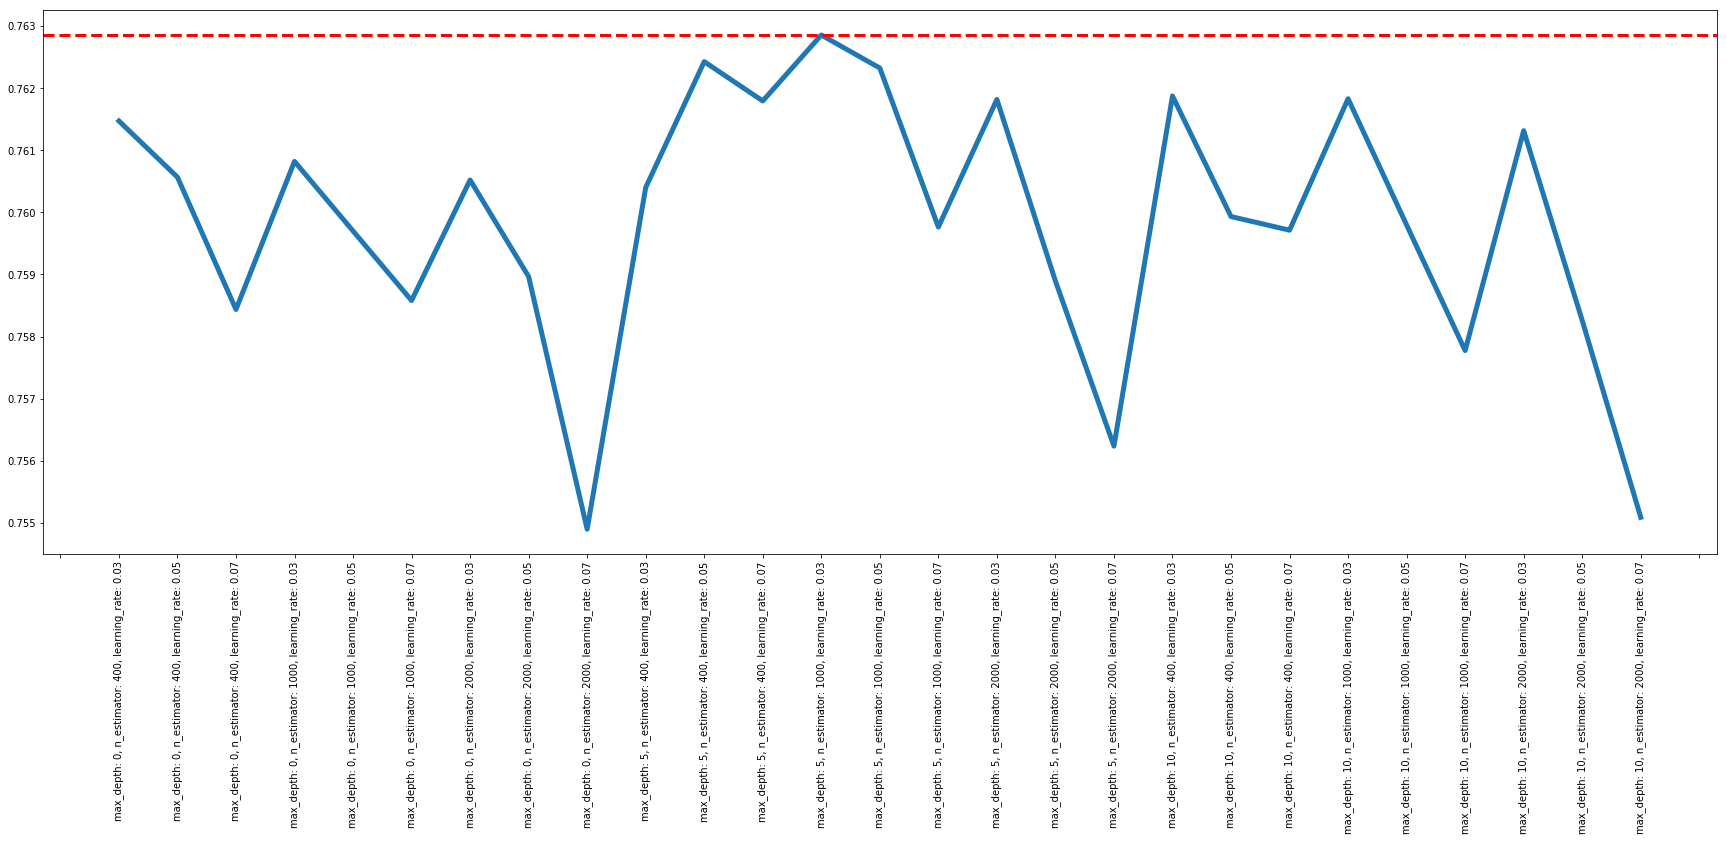

In [24]:
plt.figure(figsize=(30,10))
plt.plot(params, area_under_curve, linewidth=5)
plt.xticks(rotation=90)
ax = plt.axes()
plt.axhline(linewidth=3, linestyle ="--", color = "red" , y=max(area_under_curve))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.show()

In [25]:
print ("Best AUC ROC: %0.3f" %max(area_under_curve))

Best AUC ROC: 0.763
